In [1]:
!pip install emoji
!pip install emoji --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 6.8 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=d411282b71bf57d1ed862beb8843293c8c2d3abf56c5040508288b35f00012bd
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# enter all the required libraries
import regex
import pandas as pd
import numpy as np
import emoji
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [3]:
# create a function to prepare the dataset
def date_time(s):
  pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+), ([0-9]+):([0-9]+)[ ]?(AM|PM|am|pm)? -'
  result = regex.match(pattern, s)
  if result:
    return True
  return False

def find_author(s):
  s = s.split(":")
  if len(s)==2:
    return True
  else:
    return False

def getDatapoint(line):
  splitline = line.split(' - ')
  dateTime = splitline[0]
  date, time = dateTime.split (", ")
  message = " ".join(splitline[1:])
  if find_author(message):
    splitmessage = message.split(": ")
    author = splitmessage[0]
    message = " ".join(splitmessage[1:])
  else:
    author = None
  return date, time, author, message


In [4]:
# import raw chat data, then prepare it so that it can be used with any DataFrame

data = []
conversation = 'WhatsApp Chat with Sixth Gen.txt'
with open(conversation, encoding="utf-8") as fp:
  fp.readline()
  messageBuffer = []
  date, time, author = None, None, None
  while True:
    line = fp.readline()
    if not line:
      break
    line = line.strip()
    if date_time(line):
      if len(messageBuffer) > 0:
        data.append([date, time, author, ' '.join(messageBuffer)])
      messageBuffer.clear()
      date, time, author, message = getDatapoint(line)
      messageBuffer.append(message)
    else:
      messageBuffer.append(line)

In [5]:
# view the last 20 messages
df = pd.DataFrame(data, columns=["Date", 'Time', 'Author', 'Message'])
df['Date'] = pd.to_datetime(df['Date'])
print(df.tail(20))
print(df.info)
print(df.Author.unique())

           Date   Time             Author  \
3268 2022-01-29  22:05               Rian   
3269 2022-01-02  10:08          Abang Gas   
3270 2022-01-02  10:09          Abang Gas   
3271 2022-01-02  20:16               None   
3272 2022-01-02  20:18          Abang Gas   
3273 2022-02-26  22:08               None   
3274 2022-02-26  22:54               None   
3275 2022-02-26  23:01               None   
3276 2022-05-03  11:33           Kak Mell   
3277 2022-05-03  11:57              Sijek   
3278 2022-03-14  17:35          Abang Gas   
3279 2022-03-14  17:35          Abang Gas   
3280 2022-03-15  01:32               Rian   
3281 2022-03-21  18:45  +62 822-9468-9449   
3282 2022-03-22  10:21               None   
3283 2022-03-22  10:22  +62 822-6744-1535   
3284 2022-03-22  14:14          Abang Gas   
3285 2022-03-23  12:31  +62 822-7207-0297   
3286 2022-03-23  12:31  +62 822-7207-0297   
3287 2022-03-23  12:35  +62 822-7207-0297   

                                                Messag

In [6]:
# number of messages in this conversation
total_message = df.shape[0]
print(total_message)

3288


In [7]:
# total media sent in this conversation
media_message = df[df["Message"]=='<Media omitted>'].shape[0]
print(media_message)

577


In [8]:
# extract emoji in chat
emoticons = [':-)', ':)', '(:', '(-:', ':))', '((:', ':-D', ':D', 'X-D', 'XD', 'xD', 'xD', '<3', '</3', ':\*',
                 ';-)',
                 ';)', ';-D', ';D', '(;', '(-;', ':-(', ':(', '(:', '(-:', ':,(', ':\'(', ':"(', ':((', ':D', '=D',
                 '=)',
                 '(=', '=(', ')=', '=-O', 'O-=', ':o', 'o:', 'O:', 'O:', ':-o', 'o-:', ':P', ':p', ':S', ':s', ':@',
                 ':>',
                 ':<', '^_^', '^.^', '>.>', 'T_T', 'T-T', '-.-', '*.*', '~.~', ':*', ':-*', 'xP', 'XP', 'XP', 'Xp',
                 ':-|',
                 ':->', ':-<', '$_$', '8-)', ':-P', ':-p', '=P', '=p', ':*)', '*-*', 'B-)', 'O.o', 'X-(', ')-X']

def split_count(text):
  emoji_list = []
  data = regex.findall(r'\X', text)
  for word in data:
    if any(char in emoji.UNICODE_EMOJI['en'] for char in word):
      emoji_list.append(word)

  for word in text.split(' '):
    if word in emoticons:
      emoji_list.append(word)
  return emoji_list

df['emoji'] = df["Message"].apply(split_count)

emojis = sum(df['emoji'].str.len())
print(emojis)


316


In [9]:
# extract the link in the chat
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: regex.findall(URLPATTERN, x)).str.len()
links = np.sum(df.urlcount)

print("Order six generation grub")
print("Total Order: ", total_message)
print("The number of media shared: ", media_message)
print("Number of emojis shared: ", emojis)
print("Number of links shared: ", links)

Order six generation grub
Total Order:  3288
The number of media shared:  577
Number of emojis shared:  316
Number of links shared:  98


In [10]:
# prepare data insights for analyzing messages
media_message_df = df[df['Message'] == '<Media omitted>']
message_df = df.drop(media_message_df.index)
message_df['Letter_Count'] = message_df['Message'].apply(lambda s : len(s))
message_df['Word_Count'] = message_df['Message'].apply(lambda s : len(s.split(' ')))
message_df["MessageCount"]=1

l = ["Rian", "Kak Mell"]
for i in range(len(l)):
  # filtering users who sent messages
  req_df = message_df[message_df["Author"] == l[i]]
  
  # filter that in req_df there is only one message
  print(f'Order by {l[i]}')

  #  number of messages sent
  print('number of messages sent', req_df.shape[0])

  # Average sentences per message
  words_per_message = (np.sum(req_df['Word_Count']))/req_df.shape[0]
  print("Average sentences per message", words_per_message)

  # sent media
  media = media_message_df[media_message_df['Author'] == l[i]].shape[0]
  print("sent media ", media)

  # sent emoji
  emojis = sum (req_df['emoji'].str.len())
  print("sent emoji ", emojis)

  # sent link
  links = sum(req_df["urlcount"])
  print("sent link ", links)

Order by Rian
number of messages sent 204
Average sentences per message 4.235294117647059
sent media  35
sent emoji  1
sent link  0
Order by Kak Mell
number of messages sent 79
Average sentences per message 16.0126582278481
sent media  20
sent emoji  11
sent link  2


In [11]:
# lakukan visualisasi emoji
total_emojis_list = list(set([a for b in message_df.emoji for a in b]))
total_emojis = len (total_emojis_list)

total_emojis_list = list([a for b in message_df.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
for i in emoji_dict:
  print(i)

emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
import plotly.express as px 
fig = px.pie(emoji_df, values='count', names = 'emoji')
fig.update_traces(textposition='inside', textinfo='percent +label')
fig.show()

('😭', 25)
('😂', 24)
('🤣', 23)
('🔑', 20)
('🥺', 10)
('🙏', 9)
('📌', 9)
('🔥', 7)
(':)', 7)
('⏺', 6)
('⏹', 6)
('\U0001f971', 6)
('😇', 6)
('🙃', 6)
('😊', 5)
('😅', 5)
('⏰', 5)
('🔰', 4)
('⏩', 4)
('✨', 4)
('🙄', 4)
('🤭', 4)
('🙏🏼', 4)
('✅', 4)
('✔️', 4)
('📒', 4)
('🙏🏻', 3)
('❤️', 3)
('📱', 3)
('‼️', 3)
('👇🏻', 3)
('⚡', 3)
('🗿', 3)
('🗓', 3)
('♟️', 3)
('🔫', 2)
('🤲🏻', 2)
('🥰', 2)
('🥳', 2)
('🎓', 2)
('📅', 2)
('🖥️', 2)
('🗓️', 2)
('🗣️', 2)
(':*', 2)
('🤢', 2)
('😰', 2)
('💻', 2)
('🎉', 2)
('📍', 2)
('🏆', 2)
('📆', 2)
('😎', 1)
('🤪', 1)
('😘', 1)
('😌', 1)
('🎶', 1)
('🤔', 1)
('😏', 1)
('☹️', 1)
('🙂', 1)
('🎗️', 1)
('🎖️', 1)
('🔜', 1)
('👥', 1)
('⏱️', 1)
('📲', 1)
('🔐', 1)
('🖱️', 1)
('🚨', 1)
('🖤', 1)
('😕', 1)
('👨\u200d🏫', 1)
('🎁', 1)
('💰', 1)
('\U0001f90c🏻', 1)
('🤗', 1)
('😞', 1)
('🤮', 1)
('🤧', 1)
('👨\u200d🦱', 1)
('🕒', 1)
('🏢', 1)
('📢', 1)
('👍🏼', 1)
('👌🏻', 1)
('😁', 1)
('🙌', 1)
('👩🏻', 1)
('👇', 1)
('🐖', 1)
('🛐', 1)


There is a 96231 sentence in their message


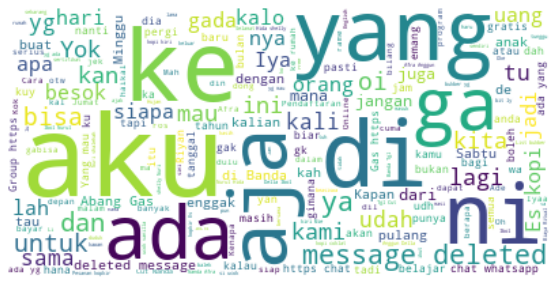

In [12]:
# visualization of the most frequently occurring words
text = " ".join(review for review in message_df.Message)
print("There is a {} sentence in their message".format(len(text)))
stopwords = set(STOPWORDS)

# make sentences in cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color = "white").generate(text)

# show the word cloud
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Writer is name  Abang Gas


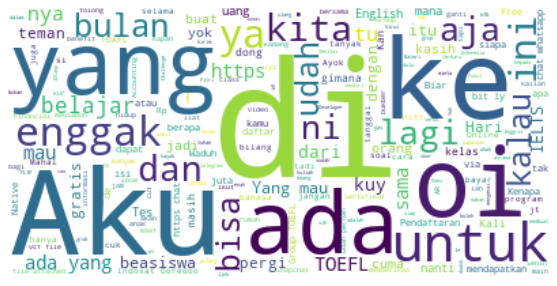

Writer is name  Rian


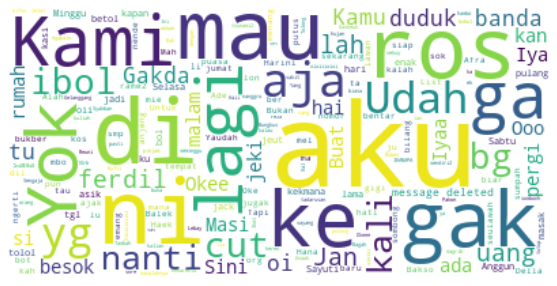

In [13]:
# words that often appear from both people
l = ["Abang Gas", "Rian"]
for i in range(len(l)):
  dummy_df = message_df[message_df['Author'] == l[i]]
  text = " ".join(review for review in dummy_df.Message)
  stopwords = set(STOPWORDS)

  # Message Author Name
  print('Writer is name ', l[i])
  wordcloud = WordCloud(stopwords=stopwords, background_color = "white").generate(text)

  # Showing pictures
  plt.figure(figsize=(10,5))
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.show()